## Labs: My Model - Iteration 2 (Solution)

In this lab project, you will build a trading model based on the popular characteristics for cheap stocks: Low Price-to-Earnings ratio and low Price-to-Book ratio.

For this first iteration, we are going to extract the alphas by simply measuring the distances between the asset's pe and pb from the mean pe and pb, respectively. This operation is called *normalization*.

## 1. Imports and Settings

Copy this code cell into the algorithm:

In [9]:
# Module Imports
# --------------------
import quantopian.optimize as opt
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import CustomFactor
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data.morningstar import Fundamentals

from quantopian.pipeline.filters import QTradableStocksUS

import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import gmean

# Environment Settings
# --------------------
## Production 
universe = QTradableStocksUS()
mask = {'mask': universe}

## Development
# universe = QTradableStocksUS()
# mask = {'mask': universe}


# Global Configuration
# --------------------

# None, 'industry', 'sector'
SCALE_BY = 'sector'
CLIP_OUTLIERS = False
CLIP_THRESHOLD =  0.025

Do not copy this code cell into the algorithm:

In [10]:
from quantopian.research import run_pipeline

# Leave at least 6 months holding period.

## Production 
start_date = datetime.strptime('01/01/2018', '%m/%d/%Y')
end_date = datetime.strptime('06/01/2019', '%m/%d/%Y')

## Development
# start_date = datetime.strptime('03/01/2020', '%m/%d/%Y')
# end_date = datetime.strptime('03/02/2020', '%m/%d/%Y')

## 2. Helpers

The code below can be copied directly into the algorithm.

In [15]:
def standardize(data, standardize_by=None, standardizer=None):
    data = pd.Series(data)
    
    # Prepare the data
    dfData = pd.DataFrame({'data': data})
    if standardize_by != None and standardizer is not None:
        dfData[standardize_by] = standardizer
    
        # Standardize the data
        zscore = lambda x: (x - x.mean()) / (x.std() == 0 and 1 or x.std())
        data = dfData.groupby([standardize_by])['data'].transform(zscore)
    
    return data


def groupscale(data, sectors):
    """ Group and scale by sectors data"""
    data = pd.Series(data)
    df = pd.DataFrame({'data': data})
    df['sector'] = sectors
    zscore = lambda x: (x - x.mean()) / (x.std() == 0 and 1 or x.std())
    return df.groupby(['sector'])['data'].transform(zscore)


def normalize(data):
    """ Normalize long/short positions
    """
    result = pd.Series(data)
    result = result - np.nanmean(data)
        
    denom = result.abs().sum()
    if denom == 0:
        denom = 1
    
    return result / denom


def clip(data, threshold=0.025, drop=False):
    data = pd.Series(data)
    data_notnull = data[data.notnull()]
    if data_notnull.shape[0] > 0:
        low_cutoff = data_notnull.quantile(threshold)
        high_cutoff = data_notnull.quantile(1 - threshold)
        if not drop:
            data = data.clip(lower=low_cutoff, upper=high_cutoff).values
        else:
            data = data[(data < low_cutoff) | (data > high_cutoff)]
    
    return data


class Scale(CustomFactor):
    """ Scale by either industry or sector.
    This is for a quick experiment to get scaled value
    of the last day. Once multiple dates are needed,
    a new factor needs to be created.
    """
    # inputs = [factor, classifier]
    inputs = [USEquityPricing.close.latest,
              Fundamentals.morningstar_industry_code.latest]
    window_length = 1
    params={
        'clip_outliers': False,
        'clip_threshold': 0.025,
        'scale_by': 'sector', # None, 'sector' or 'industry'
    }
    
    def compute(self, today, assets, out, input1, groupby, clip_outliers,
                clip_threshold, scale_by):
        data = input1[-1, :]

        out[:] = self.transform(data, groupby, clip_outliers,
                                clip_threshold, scale_by)
    
    
    def transform(self, data, groupby, clip_outliers,
                  clip_threshold, scale_by):
        
        if clip_outliers:
            data = clip(data, threshold=clip_threshold)

        groupby_data = groupby[-1, :]
        data = standardize(data,
                           standardize_by=scale_by,
                           standardizer=groupby_data)
        return data
        

# --- For combined factors ---

class Normalize(CustomFactor):
    window_length = 1
    def compute(self, today, assets, out, inp):
        data = normalize(inp[-1, :])
        out[:] = data


In [16]:
def assert_groupscale():
    data = np.array([1, 2, 3, 9, 9, 9])
    sectors = np.array([0, 0, 0, 1, 1, 1])
    result = groupscale(data, sectors)
    assert (result == np.array([-1, 0, 1, 0, 0, 0])).all(), \
           "Incorrect result: {}".format(result)
    return True
    
assert_groupscale()

True

## 3. Build Pipeline

The code below can be copied directly into the algorithm.

In [17]:
def make_alpha_factors():
    factors = {}
    # Create factors here

    if SCALE_BY == 'industry':
        scaler = Fundamentals.morningstar_industry_code
    elif SCALE_BY == 'sector':
        scaler = Fundamentals.morningstar_sector_code

    # gs = group-standardized
    a_pe_ratio_gs = Scale(
        inputs=[Fundamentals.pe_ratio.latest, scaler.latest],
        window_length=1,
        scale_by=SCALE_BY,
        clip_outliers=CLIP_OUTLIERS,
        clip_threshold=CLIP_THRESHOLD,
        **mask)
    factors['a_pe_ratio_gs'] = a_pe_ratio_gs

    a_pb_ratio_gs = Scale(
        inputs=[Fundamentals.pb_ratio.latest, scaler.latest],
        window_length=1,
        scale_by=SCALE_BY,
        clip_outliers=CLIP_OUTLIERS,
        clip_threshold=CLIP_THRESHOLD,
        **mask)
    factors['a_pb_ratio_gs'] = a_pb_ratio_gs
   
    
    factor_sum = a_pe_ratio_gs + a_pb_ratio_gs
    
    combined_alpha = Normalize(
                     inputs=[factor_sum],
    )
    factors['a_combined'] = combined_alpha
    
    return factors
                                        

def make_pipeline():
    alpha_factors = make_alpha_factors()
    factors = {a: alpha_factors[a] for a in alpha_factors}
    pipe = Pipeline(columns=factors, screen=universe)
    
    return pipe

## 4. Run Pipeline

In [18]:
pipe = make_pipeline()
mdf = run_pipeline(pipe, start_date, end_date).dropna(how='all')
mdf.head(5)

a_combined  a_pb_ratio_gs  \
2018-01-02 00:00:00+00:00 Equity(2 [ARNC])    -0.000360      -0.228407   
                          Equity(24 [AAPL])   -0.000316      -0.126692   
                          Equity(31 [ABAX])   -0.000345      -0.212212   
                          Equity(41 [ARCB])   -0.000264      -0.264815   
                          Equity(52 [ABM])    -0.000321      -0.249788   

                                             a_pe_ratio_gs  
2018-01-02 00:00:00+00:00 Equity(2 [ARNC])       -0.233983  
                          Equity(24 [AAPL])      -0.282462  
                          Equity(31 [ABAX])      -0.232083  
                          Equity(41 [ARCB])      -0.081141  
                          Equity(52 [ABM])       -0.165486

## 5. Analyze Pipeline Result

### 5.1. Validating the normalization process

Checking combined alpha of the first date. Should be close to 1.

In [10]:
first_available_date = mdf.index.get_level_values(0)[0]
selector = mdf.index.get_level_values(0) == first_available_date
mdf.loc[selector]['a_combined'].abs().sum()

0.9999999999999979

### 5.2. Distribution of values

More spread, the better.

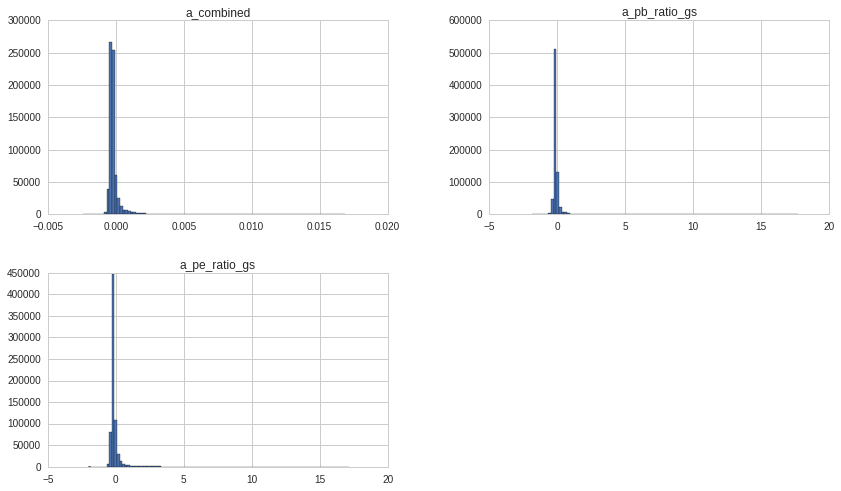

In [11]:
mdf.hist(bins=100);

### 5.3. Correlation between factors

Correlation close to 1.0 (or -1.0) means the factor is probably not needed.

In [12]:
mdf.fillna(0).corr()  # Filling NaNs with 0 assumes empty values are the mean (z-score/rank of 0)
# mdf.corr()  # Drops NaNs; results are not much different

,a_combined,a_pb_ratio_gs,a_pe_ratio_gs
a_combined,1.000000,0.542201,0.761628
a_pb_ratio_gs,0.542201,1.000000,0.007651
a_pe_ratio_gs,0.761628,0.007651,1.000000


### 5.4. Number of stocks to trade

1. Total number of stocks considered for trading throughout all dates:

In [29]:
mdf.index.get_level_values(1).unique().shape[0]

2515

2. How many stocks on average do we trade each day?

In [30]:
mdf.dropna(how='all').groupby(level=0).agg('count').mean()[0]

2037.3005617977528

## 6. Get Alpha Factors
 
We have a function below to extract alpha factors from the `factors` DataFrame we have created above. It does two things by default:

1. Replace `np.inf` and `np.nan` to 0, and
2. get the `factors['a_combined']` Series.

Although you may technically combine the alphas in this function, it is preferable to do the alpha combination step on the "Build Pipeline" step above. The reasoning:

The algorithm environment requires this function to accept a $1 \times s$ DataFrame where $s$ is the number of assets, while this research environment requires a $d \times s$ DataFrame where $d$ is the number of dates. Due to this, performing complex operations (such as getting only the extreme values of the combined alpha) may take a very long time on the Notebook environment.

In [31]:
# Note: Adjust as necessary. In here, columns that begins with 'a_' would be
#       considered alpha factors. The rest are for analysis purposes.

filter_col = [col for col in mdf if col.startswith('a_')]
alphas = mdf.loc[:, filter_col]

# Note: Copy to the algorithm

def get_alpha(factors):
    # Replace infs and NaNs
    factors[np.isinf(factors)] = np.nan
    factors.fillna(0, inplace=True)

    combined_alpha = factors['a_combined']
    return combined_alpha

The trading algorithm will use the `combined_alpha` DataFrame.

In [32]:
combined_alpha = get_alpha(alphas)

## 7. Analyze Alphas

### 7.1. Alphas' Statistics

Present some statistics of the alphas here.

In [33]:
alphas.describe()

,a_combined,a_pb_ratio_gs,a_pe_ratio_gs
count,7.704780e+05,7.704780e+05,7.704780e+05
mean,-1.111673e-22,1.233564e-18,8.655952e-18
std,1.126331e-03,9.954594e-01,9.696569e-01
min,-2.626084e-03,-2.053495e+00,-2.030023e+00
25%,-3.474804e-04,-1.919504e-01,-2.513848e-01
50%,-2.479325e-04,-1.413244e-01,-1.846938e-01
75%,-6.221756e-05,-7.180721e-02,-7.838411e-02
max,1.688695e-02,1.771068e+01,1.712369e+01


How many % of our signals are shorts?

In [36]:
median_daily_signals = alphas.groupby(level=0).count().median()
percent_short = float(combined_alpha[combined_alpha < 0.0].count()) \
                / float(combined_alpha.count())*100

print("Median number of daily signals: {}".format(median_daily_signals))
print("% of short signals: {}%".format(percent_short))

Median number of daily signals: a_combined       2158.5
a_pb_ratio_gs    2158.5
a_pe_ratio_gs    2158.5
dtype: float64
% of short signals: 77.84946487764738%


### 7.2. Alphalens Analysis

`ANALYZE_ALL` settings:

1. `True`: Analyze all alpha factors in variable `alphas` and the final `combined_alpha` variable.
2. `False`: Analyze only the final factor i.e. the `combined_alpha` variable.

In [37]:
ANALYZE_ALL = True

if ANALYZE_ALL:
    alphas_view = alphas.copy()
else:
    alphas_view = combined_alpha
alphas_view.head(5)

a_combined  a_pb_ratio_gs  \
2018-01-02 00:00:00+00:00 Equity(2 [ARNC])    -0.000360      -0.228407   
                          Equity(24 [AAPL])   -0.000316      -0.126692   
                          Equity(31 [ABAX])   -0.000345      -0.212212   
                          Equity(41 [ARCB])   -0.000264      -0.264815   
                          Equity(52 [ABM])    -0.000321      -0.249788   

                                             a_pe_ratio_gs  
2018-01-02 00:00:00+00:00 Equity(2 [ARNC])       -0.233983  
                          Equity(24 [AAPL])      -0.282462  
                          Equity(31 [ABAX])      -0.232083  
                          Equity(41 [ARCB])      -0.081141  
                          Equity(52 [ABM])       -0.165486

In [38]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 1 day, 1 week, 1 month, 1 quarter
periods = [1, 5, 22, 64]

# Get pricing data (extends 6 months to minimize dropping in Alphalens)
new_start_date = start_date - relativedelta(months=6)
new_end_date = end_date + relativedelta(months=6)
assets = alphas_view.reset_index()['level_1'].unique()
dates = alphas_view.reset_index()['level_0'].unique()
prices = get_pricing(assets, start_date=new_start_date, end_date=new_end_date, fields='close_price')
prices.head(5)

,Equity(2 [ARNC]),Equity(24 [AAPL]),Equity(31 [ABAX]),Equity(41 [ARCB]),Equity(52 [ABM]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(64 [GOLD]),Equity(67 [ADSK]),Equity(76 [TAP]),...,Equity(40848 [FLDM]),Equity(7259 [SXI]),Equity(16743 [DX]),Equity(51995 [TALO]),Equity(50695 [PSDO]),Equity(52361 [BPYU]),Equity(52362 [KLXE]),Equity(4886 [MITK]),Equity(49607 [AXSM]),Equity(38296 [RST])
2017-07-03 00:00:00+00:00,22.350,138.253,52.992,20.851,39.769,142.38,46.557,15.191,99.340,80.451,...,4.115,89.422,15.930,NaN,14.141,NaN,NaN,8.25,5.30,10.69
2017-07-05 00:00:00+00:00,22.506,138.812,52.754,20.509,39.358,142.31,46.834,15.522,102.610,80.572,...,3.770,88.396,15.976,NaN,14.496,NaN,NaN,8.20,5.15,10.49
2017-07-06 00:00:00+00:00,22.438,137.492,51.755,20.314,38.785,140.02,45.849,15.240,102.060,80.292,...,3.800,88.836,15.771,NaN,13.983,NaN,NaN,8.25,5.30,10.39
2017-07-07 00:00:00+00:00,22.624,138.889,52.052,21.046,39.320,142.12,46.299,14.963,103.320,80.237,...,3.900,89.960,15.680,NaN,14.447,NaN,NaN,8.50,5.50,10.72
2017-07-10 00:00:00+00:00,23.318,139.775,51.641,21.388,38.900,141.21,46.117,15.376,103.745,79.761,...,3.960,89.471,15.520,NaN,14.289,NaN,NaN,9.45,5.45,10.48


In [39]:
import alphalens as al
from scipy import stats

def get_table(ic_data, ab_data):
    summary_table = pd.DataFrame()
    summary_table["Ann. Alpha"] = ab_data.loc['Ann. alpha']
    summary_table["beta"] = ab_data.loc['beta']
    summary_table["IC Mean"] = ic_data.mean()
    summary_table["IC Std."] = ic_data.std()
    summary_table["Risk-Adjusted IC"] = \
        ic_data.mean() / ic_data.std()
    t_stat, p_value = stats.ttest_1samp(ic_data, 0)
    summary_table["p-value(IC)"] = p_value

    return summary_table.apply(lambda x: x.round(3)).T


results = None
for i, col in enumerate(sorted(alphas_view.columns)):
    if i > 0:
        print('')
    print(col)
    
    # Get the factor data
    data = alphas_view[col]
    data = data[data != 0].dropna()
    try:
        factor_data = al.utils.get_clean_factor_and_forward_returns(data,
                                                                    prices,
                                                                    quantiles=5,
                                                                    periods=periods,
                                                                    max_loss=1.
                                                                   )

        # Output the results
        ic = al.performance.factor_information_coefficient(factor_data)
        ic.columns = pd.MultiIndex.from_product([[col], ic.columns])

        returns = al.performance.factor_returns(factor_data)
        ab = al.performance.factor_alpha_beta(factor_data, returns=returns)
        ab.columns = pd.MultiIndex.from_product([[col], ab.columns])

        table = get_table(ic, ab)

        if results is None:
            results = table
        else:
            results = pd.concat([results, table], axis=1)
            
    except Exception as e:
        print('Error: {}'.format(e))
        continue
        
temp = None
i = 0
unique_vals = results.columns.get_level_values(0).unique()
for j, factor in enumerate(sorted(unique_vals)):
    i += 1
    res = results.xs(factor, axis=1, level=0, drop_level=False)
    
    if temp is None:
        temp = res
    else:
        temp = pd.concat([temp, res], axis=1)
        
    if i > 4 or j == len(unique_vals) - 1:
        display(temp)
        temp = None
        i = 0

a_combined
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!

a_pb_ratio_gs
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!

a_pe_ratio_gs
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!


a_combined                      a_pb_ratio_gs                \
                         1D     5D    22D    64D            1D     5D    22D   
Ann. Alpha            0.030  0.033  0.037  0.039         0.036  0.046  0.052   
beta                  0.012  0.008 -0.021  0.059         0.027  0.035  0.044   
IC Mean               0.011  0.021  0.041  0.076         0.012  0.020  0.033   
IC Std.               0.069  0.073  0.065  0.040         0.086  0.087  0.075   
Risk-Adjusted IC      0.154  0.290  0.641  1.914         0.142  0.229  0.437   
p-value(IC)           0.004  0.000  0.000  0.000         0.008  0.000  0.000   

                        a_pe_ratio_gs                       
                    64D            1D     5D    22D    64D  
Ann. Alpha        0.047         0.048  0.047  0.047  0.047  
beta              0.133         0.016  0.004 -0.033  0.038  
IC Mean           0.061         0.006  0.015  0.035  0.064  
IC Std.           0.041         0.059  0.058  0.055  0.050  
Risk-Adjusted IC  1.481         0.106  0.266  0.637  1.277  
p-value(IC)       0.000         0.047  0.000  0.000  0.000

## 8. Tear Sheet Analysis

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import empyrical as ep
import alphalens as al
import pyfolio as pf

from quantopian.research.experimental import get_factor_returns, get_factor_loadings

# Load risk factor loadings and returns
factor_loadings = get_factor_loadings(assets, start_date, new_end_date)
factor_returns = get_factor_returns(start_date, new_end_date)

# Fix a bug in the risk returns
factor_returns.loc[factor_returns.value.idxmax(), 'value'] = 0

def calc_perf_attrib(portfolio_returns, portfolio_pos, factor_returns, factor_loadings):
    start = portfolio_returns.index[0]
    end = portfolio_returns.index[-1]
    factor_loadings.index = factor_loadings.index.set_names(['dt', 'ticker'])
    portfolio_pos.index = portfolio_pos.index.set_names(['dt'])
    
    portfolio_pos = portfolio_pos.drop('cash', axis=1)
    portfolio_pos.columns.name = 'ticker'
    portfolio_pos.columns = portfolio_pos.columns.astype('int')
    
    return ep.perf_attrib(
        portfolio_returns, 
        portfolio_pos.stack().dropna(),
        factor_returns.loc[start:end], 
        factor_loadings.loc[start:end])

def plot_exposures(risk_exposures, ax=None):
    rep = risk_exposures.stack().reset_index()
    rep.columns = ['dt', 'factor', 'exposure']
    sns.boxplot(x='exposure', y='factor', data=rep, orient='h', ax=ax, order=risk_exposures.columns[::-1])

def compute_turnover(df):
    return df.dropna().unstack().dropna(how='all').fillna(0).diff().abs().sum(1)

def get_max_median_position_concentration(expos):
    longs = expos.loc[expos > 0]
    shorts = expos.loc[expos < 0]

    return expos.groupby(level=0).quantile([.05, .25, .5, .75, .95]).unstack()

def compute_factor_stats(factor, pricing, factor_returns, factor_loadings, periods=range(1, 15), view=None):
    factor_data_total = al.utils.get_clean_factor_and_forward_returns(
        factor, 
        pricing,
        quantiles=None,
        bins=(-np.inf, 0, np.inf),
        periods=periods,
        cumulative_returns=False,
    )

    portfolio_returns_total = al.performance.factor_returns(factor_data_total)
    portfolio_returns_total.columns = portfolio_returns_total.columns.map(lambda x: int(x[:-1]))
    for i in portfolio_returns_total.columns:
        portfolio_returns_total[i] = portfolio_returns_total[i].shift(i)

    portfolio_returns_specific = pd.DataFrame(columns=portfolio_returns_total.columns, index=portfolio_returns_total.index)
    
    # closure
    def calc_perf_attrib_c(i, portfolio_returns_total=portfolio_returns_total, 
                           factor_data_total=factor_data_total, factor_returns=factor_returns, 
                           factor_loadings=factor_loadings):
        return calc_perf_attrib(portfolio_returns_total[i], 
                                factor_data_total['factor'].unstack().assign(cash=0).shift(i), 
                                factor_returns, factor_loadings)
    
    if view is None:
        perf_attrib = map(calc_perf_attrib_c, portfolio_returns_total.columns)
    else:
        perf_attrib = view.map_sync(calc_perf_attrib_c, portfolio_returns_total.columns)
        
    for i, pa in enumerate(perf_attrib):
        if i == 0:
            risk_exposures_portfolio = pa[0]
            perf_attribution = pa[1]
        portfolio_returns_specific[i + 1] = pa[1]['specific_returns']
    
    delay_sharpes_total = portfolio_returns_total.apply(ep.sharpe_ratio)
    delay_sharpes_specific = portfolio_returns_specific.apply(ep.sharpe_ratio)
    
    turnover = compute_turnover(factor)
    n_holdings = factor.groupby(level=0).count()
    perc_holdings = get_max_median_position_concentration(factor)
    
    return {'factor_data_total': factor_data_total, 
            'portfolio_returns_total': portfolio_returns_total,
            'portfolio_returns_specific': portfolio_returns_specific,
            'risk_exposures_portfolio': risk_exposures_portfolio,
            'perf_attribution': perf_attribution,
            'delay_sharpes_total': delay_sharpes_total,
            'delay_sharpes_specific': delay_sharpes_specific,
            'turnover': turnover,
            'n_holdings': n_holdings,
            'perc_holdings': perc_holdings,
    }

def plot_overview_tear_sheet(factor, pricing, factor_returns, factor_loadings, periods=range(1, 15), view=None):
    fig = plt.figure(figsize=(16, 16))
    gs = plt.GridSpec(5, 4)
    ax1 = plt.subplot(gs[0:2, 0:2])
    
    factor_stats = compute_factor_stats(factor, pricing, factor_returns, factor_loadings, periods=periods, view=view)
                         
    sharpes = pd.DataFrame({'specific': factor_stats['delay_sharpes_specific'], 
                  'total': factor_stats['delay_sharpes_total']})
#     display(sharpes)
    sharpes.plot.bar(ax=ax1)
    ax1.set(xlabel='delay', ylabel='IR')

    ax2a = plt.subplot(gs[0, 2:4])
    delay_cum_rets_total = factor_stats['portfolio_returns_total'][list(range(1, 5))].apply(ep.cum_returns)
    delay_cum_rets_total.plot(ax=ax2a)
    ax2a.set(title='Total returns', ylabel='Cumulative returns')
    
    ax2b = plt.subplot(gs[1, 2:4])
    delay_cum_rets_specific = factor_stats['portfolio_returns_specific'][list(range(1, 5))].apply(ep.cum_returns)
    delay_cum_rets_specific.plot(ax=ax2b)
    ax2b.set(title='Specific returns', ylabel='Cumulative returns')
    
    ax3 = plt.subplot(gs[2:4, 0:2])
    plot_exposures(factor_stats['risk_exposures_portfolio'].reindex(columns=factor_stats['perf_attribution'].columns), 
                   ax=ax3)

    ax4 = plt.subplot(gs[2:4, 2])
    ep.cum_returns_final(factor_stats['perf_attribution']).plot.barh(ax=ax4)
    ax4.set(xlabel='Cumulative returns')

    ax5 = plt.subplot(gs[2:4, 3], sharey=ax4)
    factor_stats['perf_attribution'].apply(ep.annual_volatility).plot.barh(ax=ax5)
    ax5.set(xlabel='Ann. volatility')

    ax6 = plt.subplot(gs[-1, 0:2])
    factor_stats['n_holdings'].plot(color='b', ax=ax6)
    ax6.set_ylabel('# holdings', color='b')
    ax6.tick_params(axis='y', labelcolor='b')
    
    ax62 = ax6.twinx()
    factor_stats['turnover'].plot(color='r', ax=ax62)
    ax62.set_ylabel('turnover', color='r')
    ax62.tick_params(axis='y', labelcolor='r')
    
    ax7 = plt.subplot(gs[-1, 2:4])
    factor_stats['perc_holdings'].plot(ax=ax7)
    
    gs.tight_layout(fig)
    
    return fig, factor_stats, sharpes

/venvs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


a_combined
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


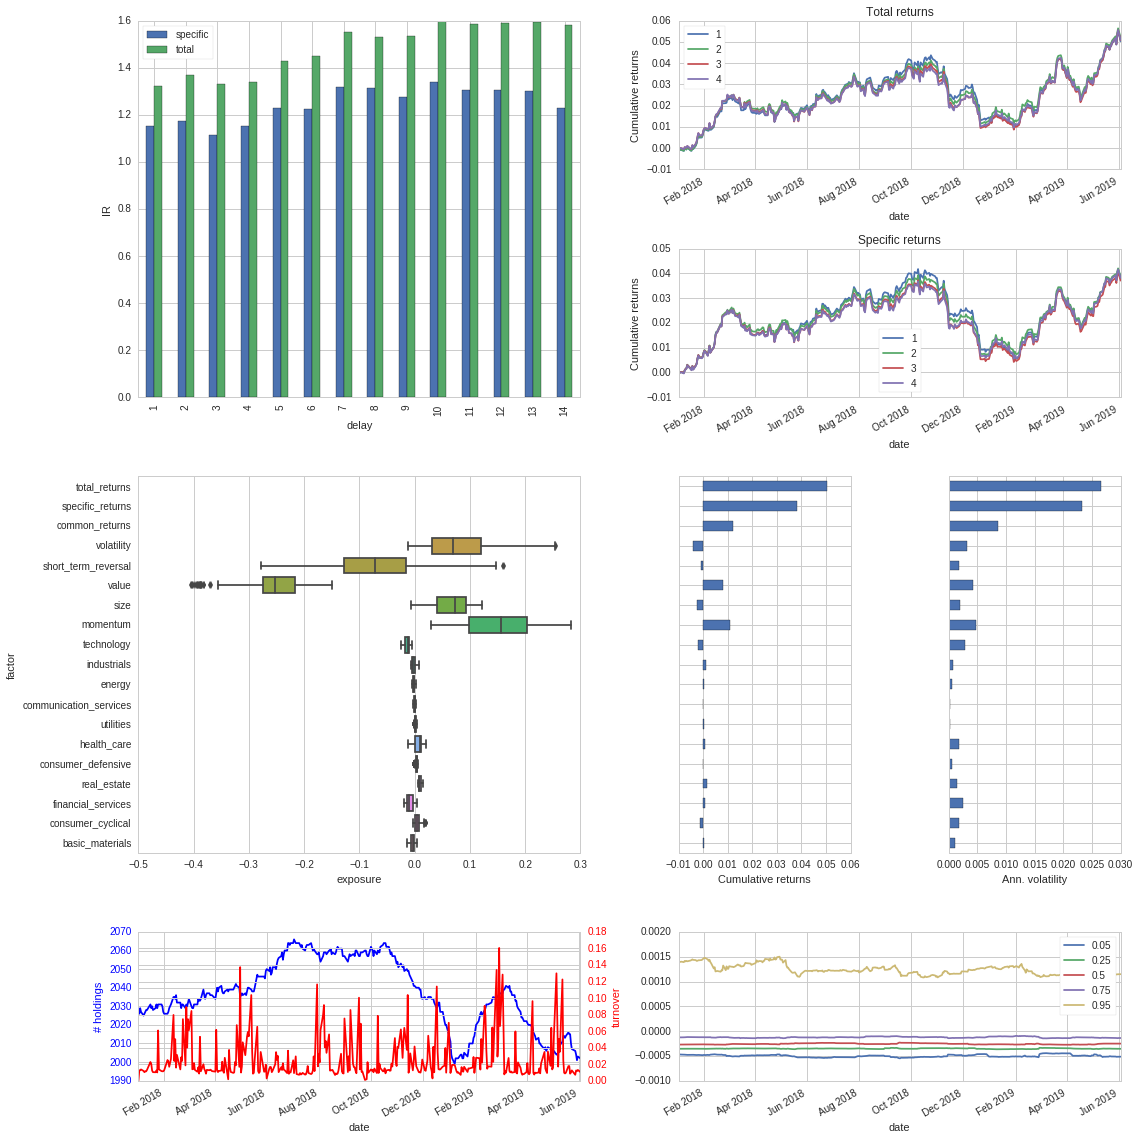


a_pb_ratio_gs
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


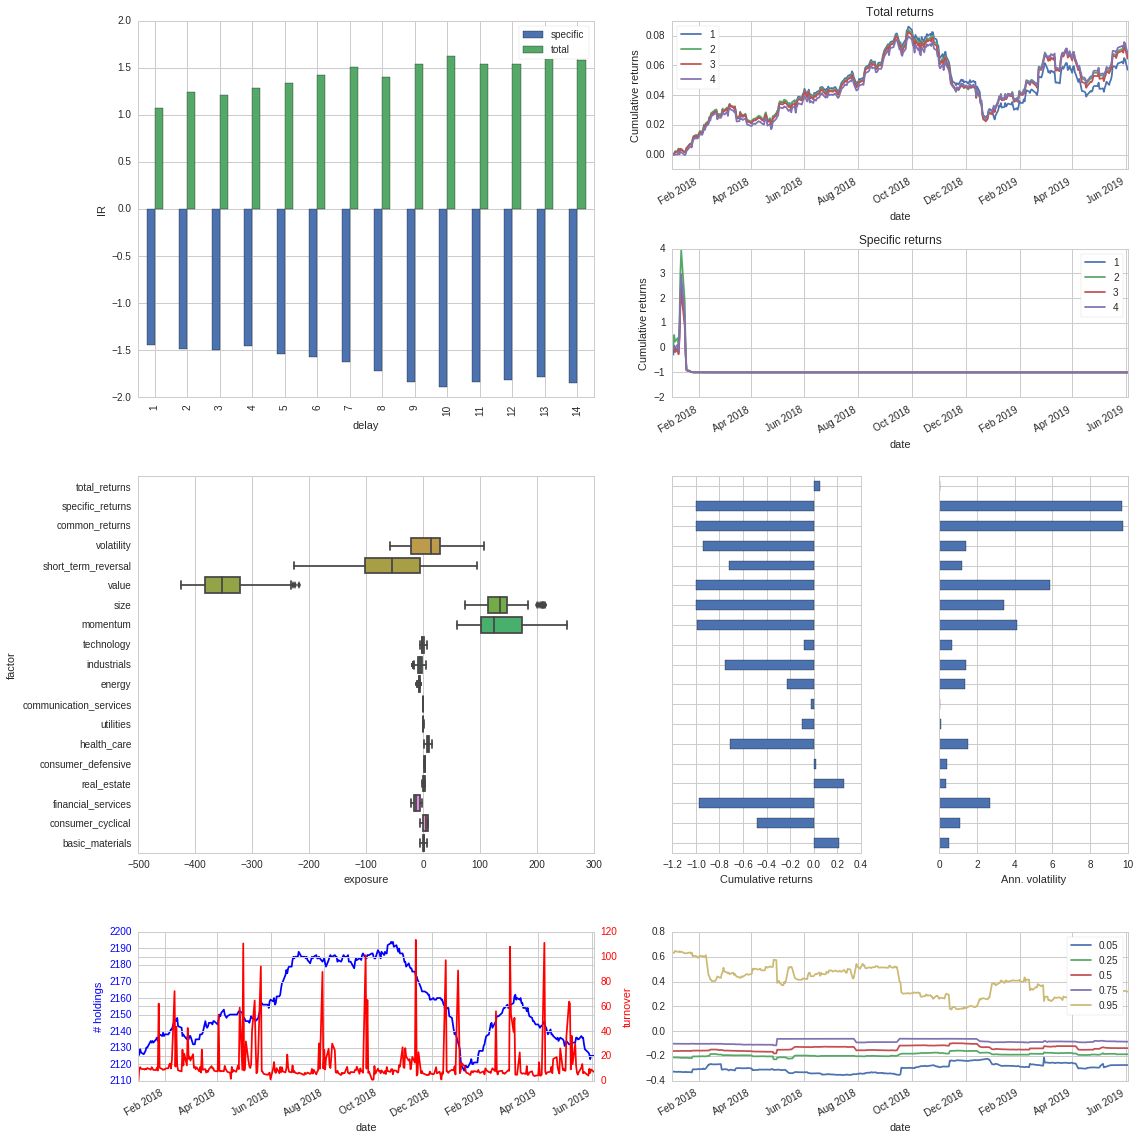


a_pe_ratio_gs
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


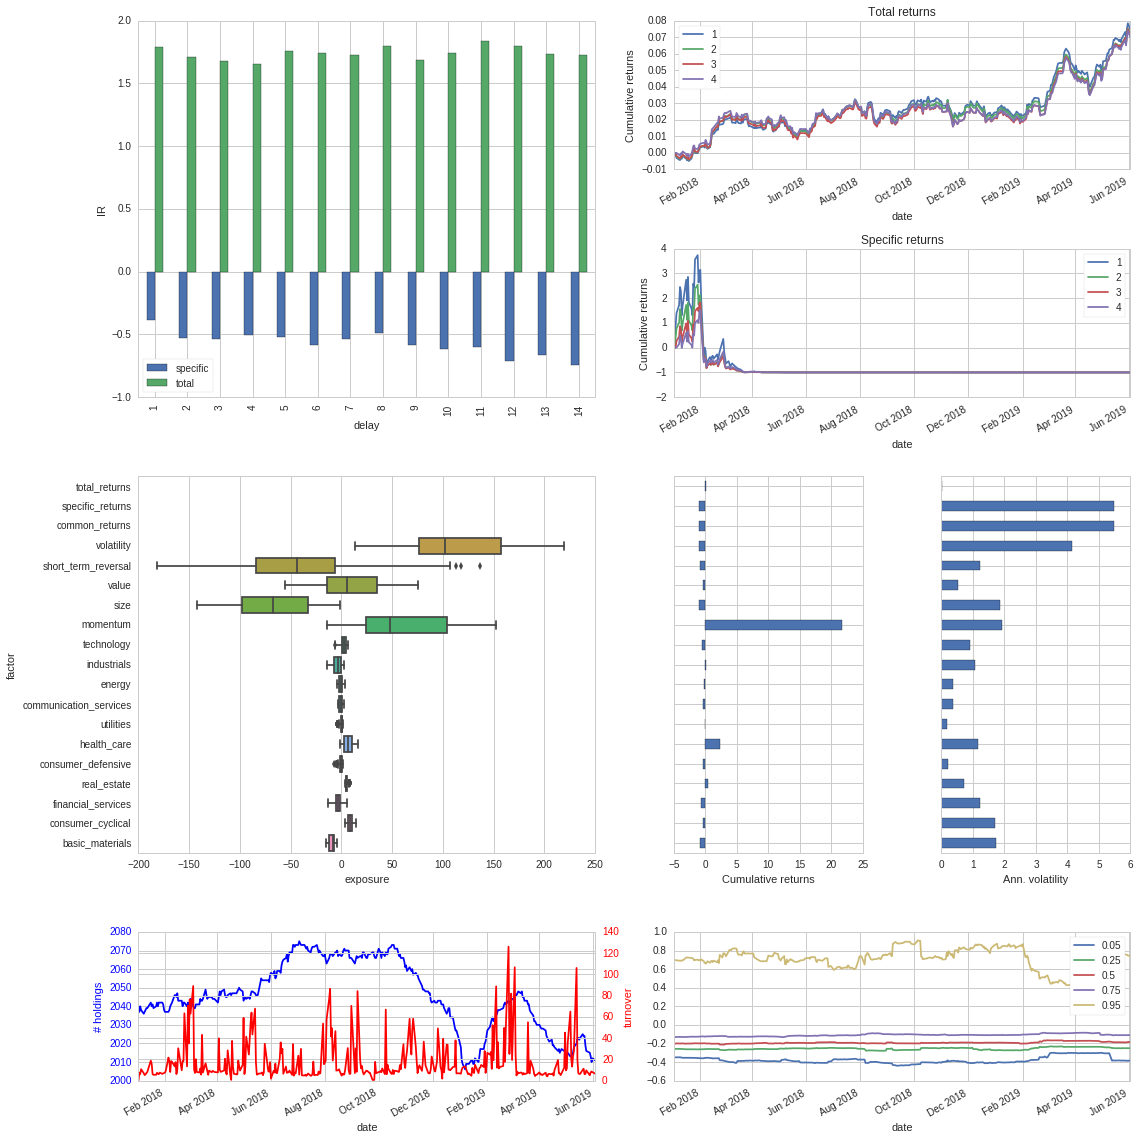

In [25]:
# Loop through all columns
results = None
for i, col in enumerate(sorted(alphas_view.columns)):
    if i > 0:
        print('')
    print(col)
    
    # Get the factor data
    try:
        data = alphas_view[col]
        data = data[data != 0].dropna()
        fig, factor_stats, sharpes = plot_overview_tear_sheet(data,
                                                     prices,
                                                     factor_returns,
                                                     factor_loadings);
        plt.show()
        
        sharpes.columns = pd.MultiIndex.from_product([[col], sharpes.columns])
        if results is None: 
            results = sharpes
        else:
            results = pd.concat([results, sharpes], axis=1)
        
    except Exception as e:
        print('Error: {}'.format(e))
        continue
        
# results